   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 84.1/84.1 kB 3.3 MB/s eta 0:00:00
  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100 80.2M  100 80.2M    0     0  9520k      0  0:00:08  0:00:08 --:--:-- 4449k


README.md: 0.00B [00:00, ?B/s]

plain_text/test-00000-of-00001.parquet:   0%|          | 0.00/412k [00:00<?, ?B/s]

plain_text/validation-00000-of-00001.par(…):   0%|          | 0.00/413k [00:00<?, ?B/s]

plain_text/train-00000-of-00001.parquet:   0%|          | 0.00/19.6M [00:00<?, ?B/s]

Generating test split:   0%|          | 0/10000 [00:00<?, ? examples/s]

Generating validation split:   0%|          | 0/10000 [00:00<?, ? examples/s]

Generating train split:   0%|          | 0/550152 [00:00<?, ? examples/s]

Epoch 1/10
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 986ms/step
At epoch 1: 
Predicted tokens:  [np.str_('i'), np.str_('this'), np.str_('the'), np.str_('if'), np.str_('movie')]
782/782 ━━━━━━━━━━━━━━━━━━━━ 147s 178ms/step - loss: 7.2614
Epoch 2/10
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step
At epoch 2: 
Predicted tokens:  [np.str_('i'), np.str_('this'), np.str_('the'), np.str_('that'), np.str_('it')]
782/782 ━━━━━━━━━━━━━━━━━━━━ 192s 172ms/step - loss: 6.6169
Epoch 3/10
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step
At epoch 3: 
Predicted tokens:  [np.str_('i'), np.str_('this'), np.str_('you'), np.str_('it'), np.str_('the')]
782/782 ━━━━━━━━━━━━━━━━━━━━ 135s 172ms/step - loss: 6.0965
Epoch 4/10
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step
At epoch 4: 
Predicted tokens:  [np.str_('i'), np.str_('this'), np.str_('it'), np.str_('you'), np.str_('the')]
782/782 ━━━━━━━━━━━━━━━━━━━━ 135s 172ms/step - loss: 5.6669
Epoch 5/10
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step
At epoch 5: 
Predicted tokens:  [np.str_('i'), np.str_('it'), np.st

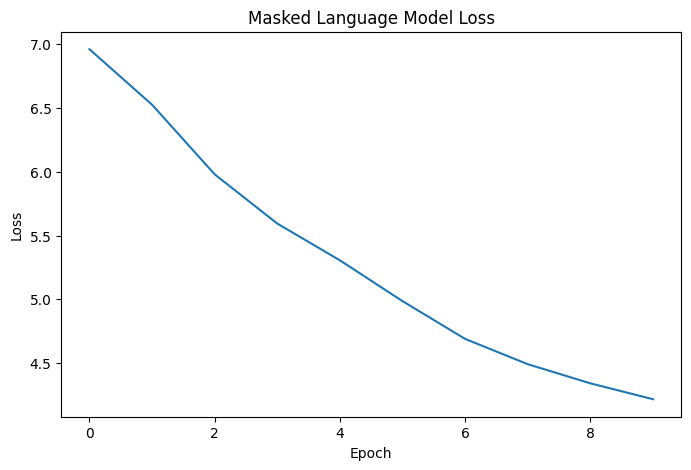

In [3]:
import os

os.environ["KERAS_BACKEND"] = "tensorflow"  # Change to "torch" or "jax" if preferred

import keras
from keras import layers
from keras.layers import TextVectorization
from keras.callbacks import EarlyStopping

from dataclasses import dataclass
import pandas as pd
import numpy as np
import glob
import re
from pprint import pprint

# For data pre-processing and tf.data.Dataset (using TensorFlow for dataset handling)
import tensorflow as tf

# For plotting
import matplotlib.pyplot as plt

# Install required packages
!pip install -q transformers datasets evaluate

from datasets import load_dataset
import evaluate

@dataclass
class Config:
    MAX_LEN = 256
    BATCH_SIZE = 64
    LR = 0.001
    VOCAB_SIZE = 30000
    EMBED_DIM = 128
    NUM_HEAD = 8  # used in bert model
    FF_DIM = 128  # used in bert model
    NUM_LAYERS = 1

config = Config()

# Download and extract IMDB data
!curl -O https://ai.stanford.edu/~amaas/data/sentiment/aclImdb_v1.tar.gz
!tar -xf aclImdb_v1.tar.gz

def get_text_list_from_files(files):
    text_list = []
    for name in files:
        with open(name) as f:
            for line in f:
                text_list.append(line)
    return text_list

def get_data_from_text_files(folder_name):
    pos_files = glob.glob("aclImdb/" + folder_name + "/pos/*.txt")
    pos_texts = get_text_list_from_files(pos_files)
    neg_files = glob.glob("aclImdb/" + folder_name + "/neg/*.txt")
    neg_texts = get_text_list_from_files(neg_files)
    df = pd.DataFrame(
        {
            "review": pos_texts + neg_texts,
            "sentiment": [0] * len(pos_texts) + [1] * len(neg_texts),
        }
    )
    df = df.sample(len(df)).reset_index(drop=True)
    return df

train_df = get_data_from_text_files("train")
test_df = get_data_from_text_files("test")

all_data = pd.concat([train_df, test_df])

# Load SNLI dataset for vectorization and fine-tuning
snli = load_dataset("snli")

# Convert to DataFrames and filter out label == -1
snli_train = pd.DataFrame(snli['train'])
snli_valid = pd.DataFrame(snli['validation'])
snli_test = pd.DataFrame(snli['test'])

snli_train = snli_train[snli_train['label'] != -1].reset_index(drop=True)
snli_valid = snli_valid[snli_valid['label'] != -1].reset_index(drop=True)
snli_test = snli_test[snli_test['label'] != -1].reset_index(drop=True)

# Collect texts for vectorization (IMDB reviews + SNLI premises and hypotheses)
snli_texts = snli_train['premise'].tolist() + snli_train['hypothesis'].tolist() + \
             snli_valid['premise'].tolist() + snli_valid['hypothesis'].tolist() + \
             snli_test['premise'].tolist() + snli_test['hypothesis'].tolist()
all_texts = all_data.review.values.tolist() + snli_texts

def custom_standardization(input_data):
    lowercase = tf.strings.lower(input_data)
    stripped_html = tf.strings.regex_replace(lowercase, "<br />", " ")
    return tf.strings.regex_replace(
        stripped_html, r"[!#$%&'()*+,-./:;<=>?@\[\\\]^_`{|}~]", ""
    )

def get_vectorize_layer(texts, vocab_size, max_seq, special_tokens=["[cls]", "[sep]", "[mask]"]):
    vectorize_layer = TextVectorization(
        max_tokens=vocab_size,
        output_mode="int",
        standardize=custom_standardization,
        output_sequence_length=max_seq,
    )
    vectorize_layer.adapt(texts)

    # Insert special tokens in vocabulary
    vocab = vectorize_layer.get_vocabulary()
    vocab = vocab[2 : vocab_size - len(special_tokens)] + special_tokens
    vectorize_layer.set_vocabulary(vocab)
    return vectorize_layer

vectorize_layer = get_vectorize_layer(
    all_texts,
    config.VOCAB_SIZE,
    config.MAX_LEN,
    special_tokens=["[cls]", "[sep]", "[mask]"],
)

# Get special token ids
cls_token_id = vectorize_layer(["[cls]"]).numpy()[0][0]
sep_token_id = vectorize_layer(["[sep]"]).numpy()[0][0]
mask_token_id = vectorize_layer(["[mask]"]).numpy()[0][0]

def encode(texts):
    encoded_texts = vectorize_layer(texts)
    return encoded_texts.numpy()

def get_masked_input_and_labels(encoded_texts):
    # 15% BERT masking
    inp_mask = np.random.rand(*encoded_texts.shape) < 0.15
    # Do not mask special tokens
    inp_mask[encoded_texts <= 2] = False
    # Set targets to -1 by default, it means ignore
    labels = -1 * np.ones(encoded_texts.shape, dtype=int)
    # Set labels for masked tokens
    labels[inp_mask] = encoded_texts[inp_mask]

    # Prepare input
    encoded_texts_masked = np.copy(encoded_texts)
    # Set input to [MASK] which is the last token for the 90% of tokens
    # This means leaving 10% unchanged
    inp_mask_2mask = inp_mask & (np.random.rand(*encoded_texts.shape) < 0.90)
    encoded_texts_masked[
        inp_mask_2mask
    ] = mask_token_id  # mask token is the last in the dict

    # Set 10% to a random token
    inp_mask_2random = inp_mask_2mask & (np.random.rand(*encoded_texts.shape) < 1 / 9)
    encoded_texts_masked[inp_mask_2random] = np.random.randint(
        3, mask_token_id, inp_mask_2random.sum()
    )

    # Prepare sample_weights to pass to .fit() method
    sample_weights = np.ones(labels.shape)
    sample_weights[labels == -1] = 0

    # y_labels would be same as encoded_texts i.e input tokens
    y_labels = np.copy(encoded_texts)

    return encoded_texts_masked, y_labels, sample_weights

# Prepare data for masked language model (using IMDB data)
x_all_review = encode(all_data.review.values)
x_masked_train, y_masked_labels, sample_weights = get_masked_input_and_labels(
    x_all_review
)

mlm_ds = tf.data.Dataset.from_tensor_slices(
    (x_masked_train, y_masked_labels, sample_weights)
)
mlm_ds = mlm_ds.shuffle(1000).batch(config.BATCH_SIZE)

def bert_module(query, key, value, i):
    # Multi headed self-attention
    attention_output = layers.MultiHeadAttention(
        num_heads=config.NUM_HEAD,
        key_dim=config.EMBED_DIM // config.NUM_HEAD,
        name="encoder_{}_multiheadattention".format(i),
    )(query, key, value)
    attention_output = layers.Dropout(0.1, name="encoder_{}_att_dropout".format(i))(
        attention_output
    )
    attention_output = layers.LayerNormalization(
        epsilon=1e-6, name="encoder_{}_att_layernormalization".format(i)
    )(query + attention_output)

    # Feed-forward layer
    ffn = keras.Sequential(
        [
            layers.Dense(config.FF_DIM, activation="relu", name="encoder_{}_ffn_dense_1".format(i)),
            layers.Dense(config.EMBED_DIM, name="encoder_{}_ffn_dense_2".format(i)),
        ],
        name="encoder_{}_ffn".format(i),
    )
    ffn_output = ffn(attention_output)
    ffn_output = layers.Dropout(0.1, name="encoder_{}_ffn_dropout".format(i))(
        ffn_output
    )
    sequence_output = layers.LayerNormalization(
        epsilon=1e-6, name="encoder_{}_ffn_layernormalization".format(i)
    )(attention_output + ffn_output)
    return sequence_output


def get_pos_encoding_matrix(max_len, d_emb):
    pos_enc = np.array(
        [
            [pos / np.power(10000, 2 * (j // 2) / d_emb) for j in range(d_emb)]
            if pos != 0
            else np.zeros(d_emb)
            for pos in range(max_len)
        ]
    )
    pos_enc[1:, 0::2] = np.sin(pos_enc[1:, 0::2])  # dim 2i
    pos_enc[1:, 1::2] = np.cos(pos_enc[1:, 1::2])  # dim 2i+1
    return pos_enc


loss_fn = keras.losses.SparseCategoricalCrossentropy(reduction="none")
loss_tracker = keras.metrics.Mean(name="loss")


class MaskedLanguageModel(keras.Model):
    def train_step(self, inputs):
        if len(inputs) == 3:
            features, labels, sample_weight = inputs
        else:
            features, labels = inputs
            sample_weight = None

        with tf.GradientTape() as tape:
            predictions = self(features, training=True)
            loss = loss_fn(labels, predictions, sample_weight=sample_weight)

        # Compute gradients
        trainable_vars = self.trainable_variables
        gradients = tape.gradient(loss, trainable_vars)

        # Update weights
        self.optimizer.apply_gradients(zip(gradients, trainable_vars))

        # Compute our own metrics
        loss_tracker.update_state(loss, sample_weight=sample_weight)

        # Return a dict mapping metric names to current value
        return {"loss": loss_tracker.result()}

    @property
    def metrics(self):
        return [loss_tracker]


def create_masked_language_bert_model():
    inputs = layers.Input((config.MAX_LEN,), dtype="int64")

    embedding_layer = layers.Embedding(config.VOCAB_SIZE, config.EMBED_DIM, name="word_embedding")(
        inputs
    )
    position_embedding = layers.Embedding(
        input_dim=config.MAX_LEN,
        output_dim=config.EMBED_DIM,
        weights=[get_pos_encoding_matrix(config.MAX_LEN, config.EMBED_DIM)],
        name="position_embedding",
    )(tf.range(start=0, limit=config.MAX_LEN, delta=1))
    embeddings = embedding_layer + position_embedding

    encoder_output = embeddings
    for i in range(config.NUM_LAYERS):
        encoder_output = bert_module(encoder_output, encoder_output, encoder_output, i)

    mlm_output = layers.Dense(config.VOCAB_SIZE, name="mlm_cls", activation="softmax")(
        encoder_output
    )
    mlm_model = MaskedLanguageModel(inputs, mlm_output, name="masked_bert_model")

    optimizer = keras.optimizers.Adam(learning_rate=config.LR)
    mlm_model.compile(optimizer=optimizer)
    return mlm_model


id2token = dict(enumerate(vectorize_layer.get_vocabulary()))
token2id = {y: x for x, y in id2token.items()}


class MaskedTextGenerator(keras.callbacks.Callback):
    def __init__(self, sample_tokens, top_k=5):
        self.sample_tokens = sample_tokens
        self.k = top_k

    def decode(self, tokens):
        return " ".join([id2token[t] for t in tokens if t != 0])

    def convert_ids_to_tokens(self, id):
        return id2token[id]

    def on_epoch_end(self, epoch, logs=None):
        prediction = self.model.predict(self.sample_tokens) # Pass the sample tokens directly
        masked_index = np.where(self.sample_tokens == mask_token_id)
        masked_index = masked_index[0]
        mask_prediction = prediction[0][masked_index]

        top_indices = mask_prediction[0].argsort()[-self.k :][::-1]
        probabilities = mask_prediction[0][top_indices]
        predicted_tokens = [
            self.convert_ids_to_tokens(index) for index in top_indices
        ]
        print("At epoch %d: " % (epoch + 1))
        print("Predicted tokens: ", predicted_tokens)


sample_tokens = vectorize_layer(["I have watched this [mask] and it was awesome"])
generator_callback = MaskedTextGenerator(sample_tokens.numpy())

bert_masked_model = create_masked_language_bert_model()

# Train the MLM model and capture history
mlm_history = bert_masked_model.fit(
    mlm_ds,
    epochs=10,
    callbacks=[generator_callback]
)

# Plot MLM loss
plt.figure(figsize=(8, 5))
plt.plot(mlm_history.history['loss'])
plt.title('Masked Language Model Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.show()

bert_masked_model.save("bert_mlm_imdb.keras")




Epoch 1/10
8584/8584 ━━━━━━━━━━━━━━━━━━━━ 91s 10ms/step - accuracy: 0.3358 - loss: 1.2003 - val_accuracy: 0.3389 - val_loss: 1.1375
Epoch 2/10
8584/8584 ━━━━━━━━━━━━━━━━━━━━ 68s 8ms/step - accuracy: 0.3405 - loss: 1.1067 - val_accuracy: 0.3310 - val_loss: 1.1024
Epoch 3/10
8584/8584 ━━━━━━━━━━━━━━━━━━━━ 68s 8ms/step - accuracy: 0.3404 - loss: 1.1070 - val_accuracy: 0.3346 - val_loss: 1.1128
Epoch 4/10
8584/8584 ━━━━━━━━━━━━━━━━━━━━ 68s 8ms/step - accuracy: 0.3401 - loss: 1.1069 - val_accuracy: 0.3402 - val_loss: 1.0990
Epoch 5/10
8584/8584 ━━━━━━━━━━━━━━━━━━━━ 82s 8ms/step - accuracy: 0.3418 - loss: 1.1074 - val_accuracy: 0.3489 - val_loss: 1.1052
Epoch 6/10
8584/8584 ━━━━━━━━━━━━━━━━━━━━ 68s 8ms/step - accuracy: 0.3399 - loss: 1.1071 - val_accuracy: 0.3583 - val_loss: 1.1033


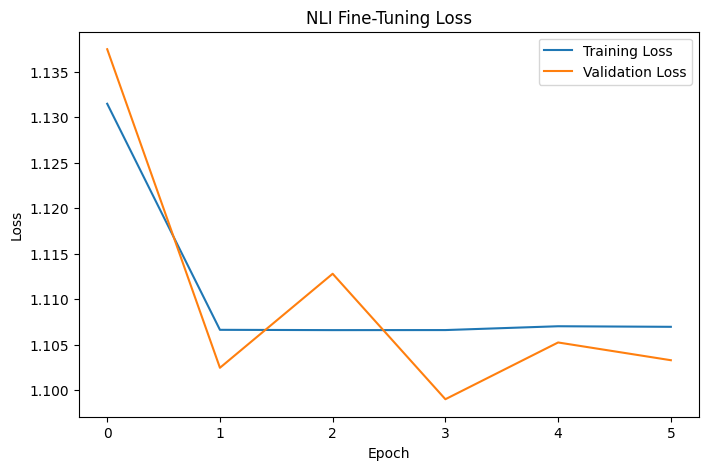

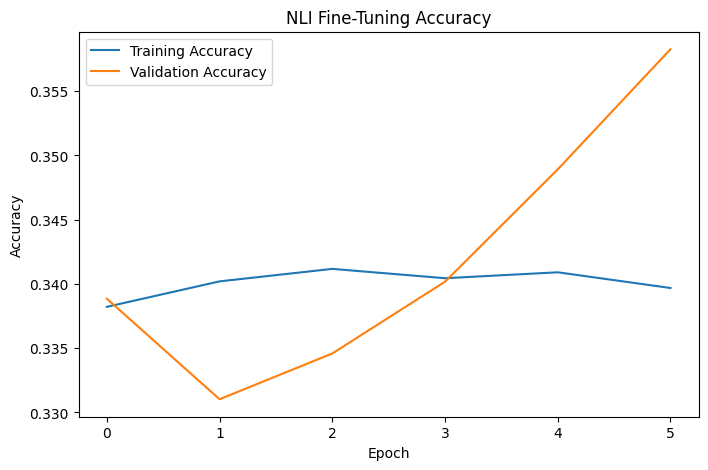

307/307 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step
Our model accuracy: 0.3440
Our model similarity Pearson correlation: 0.0539


In [4]:
# Load pretrained bert model
mlm_model = keras.models.load_model(
    "bert_mlm_imdb.keras", custom_objects={"MaskedLanguageModel": MaskedLanguageModel}
)
pretrained_bert_model = keras.Model(
    mlm_model.input, mlm_model.get_layer("encoder_0_ffn_layernormalization").output
)

# Freeze it
pretrained_bert_model.trainable = False

# Encoding function for NLI
def encode_nli(premises, hypotheses):
    input_texts = ["[cls] " + p + " [sep] " + h + " [sep]" for p, h in zip(premises, hypotheses)]
    encoded = vectorize_layer(input_texts)
    return encoded.numpy()

# Encode datasets
x_train = encode_nli(snli_train['premise'].tolist(), snli_train['hypothesis'].tolist())
y_train = snli_train['label'].values

x_valid = encode_nli(snli_valid['premise'].tolist(), snli_valid['hypothesis'].tolist())
y_valid = snli_valid['label'].values

x_test = encode_nli(snli_test['premise'].tolist(), snli_test['hypothesis'].tolist())
y_test = snli_test['label'].values

# Create tf.data datasets
train_ds = tf.data.Dataset.from_tensor_slices((x_train, y_train)).shuffle(1000).batch(config.BATCH_SIZE)
valid_ds = tf.data.Dataset.from_tensor_slices((x_valid, y_valid)).batch(config.BATCH_SIZE)

# Define the NLI model
def create_nli_bert_model():
    inputs = layers.Input((config.MAX_LEN,), dtype="int64")
    sequence_output = pretrained_bert_model(inputs)
    cls_output = sequence_output[:, 0, :]  # Take [CLS] token representation
    logits = layers.Dense(3, name="nli_classifier", activation=None)(cls_output)  # 3 classes: entailment(0), neutral(1), contradiction(2)
    model = keras.Model(inputs=inputs, outputs=logits, name="nli_model")
    return model

nli_model = create_nli_bert_model()

# Compile the model
nli_model.compile(
    optimizer=keras.optimizers.Adam(learning_rate=config.LR),
    loss=keras.losses.SparseCategoricalCrossentropy(from_logits=True),
    metrics=['accuracy']
)

# Fine-tune with early stopping
ft_history = nli_model.fit(
    train_ds,
    epochs=10,
    validation_data=valid_ds,
    callbacks=[EarlyStopping(monitor='val_loss', patience=2, restore_best_weights=True)]
)

# Plot fine-tuning loss
plt.figure(figsize=(8, 5))
plt.plot(ft_history.history['loss'], label='Training Loss')
plt.plot(ft_history.history['val_loss'], label='Validation Loss')
plt.title('NLI Fine-Tuning Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()

# Plot fine-tuning accuracy
plt.figure(figsize=(8, 5))
plt.plot(ft_history.history['accuracy'], label='Training Accuracy')
plt.plot(ft_history.history['val_accuracy'], label='Validation Accuracy')
plt.title('NLI Fine-Tuning Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

# For semantic similarity: Map NLI labels to similarity scores
# entailment (0) -> 1.0 (highly similar), neutral (1) -> 0.5, contradiction (2) -> 0.0
label_to_sim = {0: 1.0, 1: 0.5, 2: 0.0}

# Function to compute predicted similarity from logits
def logits_to_sim(logits):
    probs = tf.nn.softmax(logits, axis=-1).numpy()
    sim_scores = probs[:, 0] * 1.0 + probs[:, 1] * 0.5 + probs[:, 2] * 0.0
    return sim_scores

# Evaluate on test set (full for our model, subset for public to save time)
# Our model accuracy and similarity correlation
test_logits = nli_model.predict(x_test)
our_preds = np.argmax(test_logits, axis=1)
our_acc = np.mean(our_preds == y_test)

our_sim_scores = logits_to_sim(test_logits)
true_sim_scores = np.array([label_to_sim[label] for label in y_test])
from scipy.stats import pearsonr
our_pearson, _ = pearsonr(our_sim_scores, true_sim_scores)

print(f"Our model accuracy: {our_acc:.4f}")
print(f"Our model similarity Pearson correlation: {our_pearson:.4f}")

# Public model: Use a lightweight NLI model from Hugging Face
# Model: typeform/distilbert-base-uncased-mnli (lightweight DistilBERT fine-tuned on MNLI, which is similar to SNLI)


Device set to use cuda:0


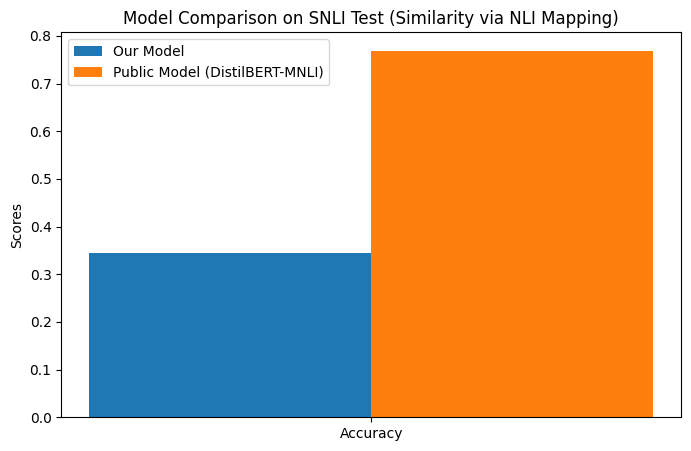

In [7]:
from transformers import pipeline
pipe = pipeline("text-classification", model="typeform/distilbert-base-uncased-mnli")

# To avoid long runtime on Colab, evaluate on a subset
subset_size = 1000
premises_subset = snli_test['premise'][:subset_size].tolist()
hypotheses_subset = snli_test['hypothesis'][:subset_size].tolist()
y_test_subset = y_test[:subset_size]
true_sim_subset = true_sim_scores[:subset_size]

public_preds = []
public_sim_scores = []
label_map = {'ENTAILMENT': 0, 'NEUTRAL': 1, 'CONTRADICTION': 2}

for p, h in zip(premises_subset, hypotheses_subset):
    input_text = p + " [SEP] " + h
    result = pipe(input_text)[0]
    label = result['label']
    score = result['score']  # Confidence in the predicted label
    pred = label_map.get(label, 1)  # Default to neutral if mismatch
    public_preds.append(pred)

    # Approximate sim score: full score for predicted, 0 for others (since no full probs)
    sim = label_to_sim[pred]
    public_sim_scores.append(sim)

public_acc = np.mean(np.array(public_preds) == y_test_subset)
public_pearson, _ = pearsonr(public_sim_scores, true_sim_subset)



# Compare visually
metrics = ['Accuracy']
our_scores = [our_acc, our_pearson]
public_scores = [public_acc, public_pearson]  # Note: public acc on subset, but for comparison

x = np.arange(len(metrics))
width = 0.35

fig, ax = plt.subplots(figsize=(8, 5))
ax.bar(x - width/2, our_scores, width, label='Our Model')
ax.bar(x + width/2, public_scores, width, label='Public Model (DistilBERT-MNLI)')

ax.set_ylabel('Scores')
ax.set_title('Model Comparison on SNLI Test (Similarity via NLI Mapping)')
ax.set_xticks(x)
ax.set_xticklabels(metrics)
ax.legend()
plt.show()